# How to perform CSEP consistency tests

This notebook follows the `pyCSEP` documentation, which can be found [here](https://docs.cseptesting.org/index.html).

It assumes that daily forecasts have been simulated by running

  ```bash
  python simulate_catalog_continuation.py [dataset] [day_of_forecast]
  ```
Where [day_of_forecast] is the integer number of days from the beginning of the testing period and `[dataset]` is one of `ComCat_25|SaltonSea_10|SanJac_10|SCEDC_20|WHITE_06|`.

We begin by loading pycsep along with some other required libraries.

In [24]:
import json
import datetime as dt
import matplotlib.pyplot as plt
import pandas as pd
import cartopy 
import numpy as np
from itertools import product

import csep
from csep.core import regions
from csep.utils import datasets, time_utils

We then define the path to the output of the ETAS parameter inversion.

In [29]:
output_dr = '../ETAS/output_data_ComCat_25'
with open(output_dr+'/parameters_0.json', 'r') as f:
        inversion_output = json.load(f)

output_dr = '../ETAS/output_data_SCEDC_20'
with open(output_dr+'/parameters_0.json', 'r') as f:
        inversion_output = json.load(f)

## Define the spatial and magnitude regions

Before we can conduct the tests, we need to define a spatial region and a set of magnitude bin edges. The magnitude bin edges # are the lower bound (inclusive) except for the last bin, which is treated as extending to infinity.

In [30]:
# Magnitude bins properties
min_mw = inversion_output['mc']							
max_mw = 7.65
dmw = 0.1

# Create space and magnitude regions
magnitudes = regions.magnitude_bins(min_mw, max_mw, dmw)
region = regions.california_relm_region()
region = csep.core.regions.CartesianGrid2D.from_origins(                   
			np.array(list(product(
				np.arange(-122, -114, 0.05), np.arange(32,37, 0.05)
			)))
		)

# Bind region information to the forecast
space_magnitude_region = regions.create_space_magnitude_region(region, magnitudes)

## Load the forecast data

In [38]:
# define forecast time period
day = 2011

path_to_forecasts = output_dr + '/CSEP_day_'+str(day)+'_.csv'

start_time = time_utils.strptime_to_utc_datetime(inversion_output['timewindow_end'])+ dt.timedelta(days=day)
end_time = start_time + dt.timedelta(days=1)

# load the forecast
ETAS_forecast = csep.load_catalog_forecast(
path_to_forecasts,
start_time=start_time, end_time=end_time,
region=space_magnitude_region,
filter_spatial = True,
apply_filters=True
)

ETAS_forecast.filters = [f'origin_time >= {ETAS_forecast.start_epoch}', f'origin_time < {ETAS_forecast.end_epoch}', f'magnitude >= {ETAS_forecast.min_magnitude}']

In [39]:
# define forecast time period

# path_to_forecasts =  '../SMASH/SMASH_daily_forecasts/ComCat/CSEP_day_'+str(day)+'.csv'
path_to_forecasts =  '../SMASH/SMASH_daily_forecasts/SCEDC/CSEP_day_'+str(day)+'.csv'

# ../SMASH/SMASH_daily_forecasts/ComCat/CSEP_test_day_1190.csv

df = pd.read_csv(
					path_to_forecasts,
					# index_col=[0],
					# header=None,
					# parse_dates=["time"],
				)
df['event_id'] = range(1, len(df) + 1)


df.to_csv(path_to_forecasts, index=False)

start_time = time_utils.strptime_to_utc_datetime(inversion_output['timewindow_end'])+ dt.timedelta(days=day)
end_time = start_time + dt.timedelta(days=1)

# load the forecast
SMASH_forecast = csep.load_catalog_forecast(
path_to_forecasts,
start_time=start_time, end_time=end_time,
region=space_magnitude_region,
filter_spatial = True,
apply_filters=True
)

SMASH_forecast.filters = [f'origin_time >= {SMASH_forecast.start_epoch}', f'origin_time < {SMASH_forecast.end_epoch}', f'magnitude >= {SMASH_forecast.min_magnitude}']

FileNotFoundError: [Errno 2] No such file or directory: '../SMASH/SMASH_daily_forecasts/SCEDC/CSEP_day_2011.csv'

In [40]:
# define forecast time period

# path_to_forecasts =  '../Spatio-temporal-Diffusion-Point-Processes/DSTPP_daily_forecasts/ComCat/CSEP_day_'+str(day)+'.csv'
path_to_forecasts =  '../Spatio-temporal-Diffusion-Point-Processes/DSTPP_daily_forecasts/SCEDC/CSEP_day_'+str(day)+'.csv'

# ../SMASH/SMASH_daily_forecasts/ComCat/CSEP_test_day_1190.csv

df = pd.read_csv(
					path_to_forecasts,
					# index_col=[0],
					# header=None,
					# parse_dates=["time"],
				)
df['event_id'] = range(1, len(df) + 1)
df.to_csv(path_to_forecasts, index=False)



start_time = time_utils.strptime_to_utc_datetime(inversion_output['timewindow_end'])+ dt.timedelta(days=day)
end_time = start_time + dt.timedelta(days=1)

# load the forecast
DSTPP_forecast = csep.load_catalog_forecast(
path_to_forecasts,
start_time=start_time, end_time=end_time,
region=space_magnitude_region,
filter_spatial = True,
apply_filters=True
)

DSTPP_forecast.filters = [f'origin_time >= {DSTPP_forecast.start_epoch}', f'origin_time < {DSTPP_forecast.end_epoch}', f'magnitude >= {DSTPP_forecast.min_magnitude}']

## Define the observed catalog

We load the observed data and filter it to be compared with the daily forecast.

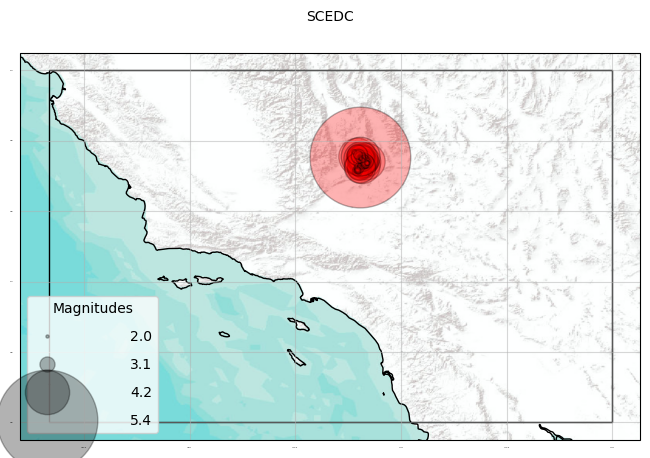

In [41]:
############# define observed catalog
# cat = csep.load_catalog('../ETAS/output_data_ComCat_25/CSEP_format_catalog.csv')		
# cat.name = 'ComCat'

cat = csep.load_catalog('../ETAS/output_data_SCEDC_20/CSEP_format_catalog.csv')		
cat.name = 'SCEDC'

cat = cat.filter_spatial(ETAS_forecast.region)
cat = cat.filter(f'magnitude >= {min_mw}')
cat = cat.filter(ETAS_forecast.filters)	


ax_2 = cat.plot()
plt.show()
# fn_result = output_dr+'/tests_CSEP_day_'+str(day)+'_'	

## Plot expected event counts

We can plot the expected event counts in each bin to visualise the day's forecast.

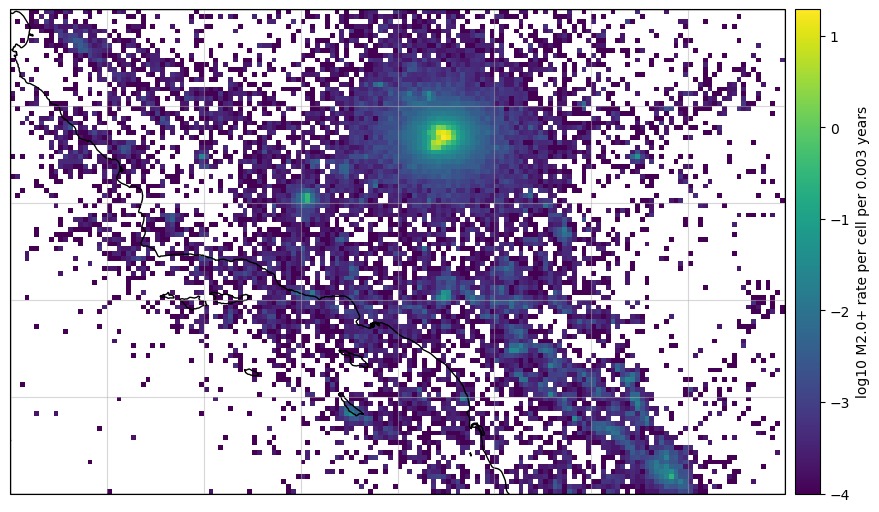

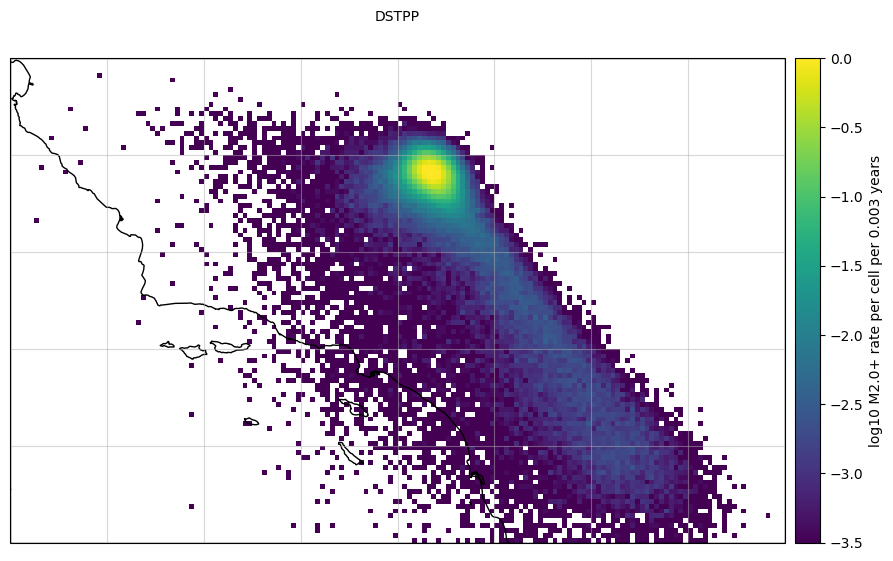

In [42]:
# args_forecast = {'grid_labels': True,
# # 'basemap': 'ESRI_imagery', # set background image if non
# # 'cmap': 'rainbow', # color palette for the logarithm of
# 'alpha_exp': 1, # level of trasparency
# 'projection': cartopy.crs.Mercator(), # projection
# 'clim':[-4, 1]}

_ = ETAS_forecast.get_expected_rates(verbose=False, )
ax = ETAS_forecast.expected_rates.plot( show=True)
# ax_2 = cat.plot(ax=ax)
plt.show()
# _ = SMASH_forecast.get_expected_rates(verbose=False, )
# ax = SMASH_forecast.expected_rates.plot(plot_args={'title': 'SMASH','clim': [-3.5, 0]}, show=True)
# # ax_2 = cat.plot(ax=ax)
# plt.show()
_ = DSTPP_forecast.get_expected_rates(verbose=False, )
ax = DSTPP_forecast.expected_rates.plot(plot_args={'title': 'DSTPP','clim': [-3.5, 0]}, show=True)
# ax_2 = cat.plot(ax=ax)
plt.show()


## Number test

Aim: The number test aims to evaluate if the number of observed events is consistent with the forecast.

Method: The observed statistic in this case is given by $N_{obs}$, which is simply the number of events in the observed catalog. To build the test distribution from the forecast, we simply count the number of events in each simulated catalog $N_j$ (for $j=1,\dots,J$ repeat simulations).

We can then evaluate the probabilities of at least and at most N events, in this case using the empirical cumlative distribution function of $F_N$:

$$\delta_1 = \mathbb{P}(N_j \geq N_{obs}) = 1 - F_N(N_{obs}-1)$$

and

$$\delta_2 = \mathbb{P}(N_j \leq N_{obs}) = 1 - F_N(N_{obs})$$

This can be performed in `pyCSEP` like this.

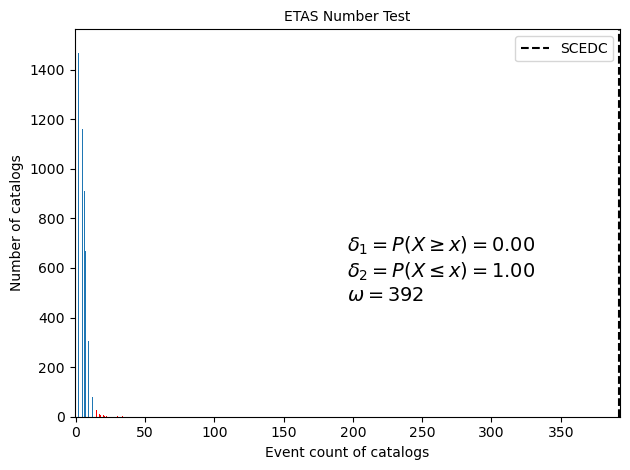

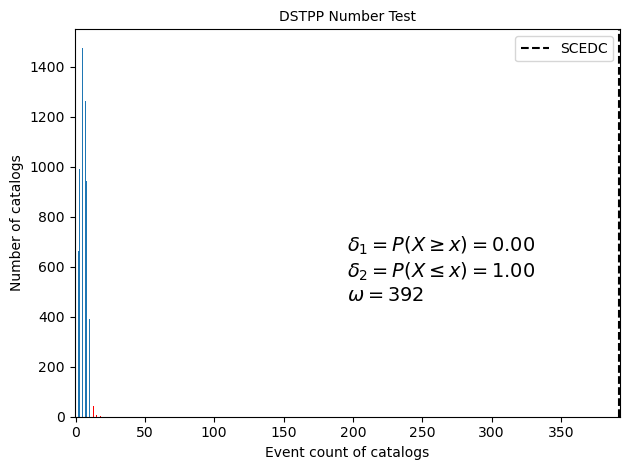

In [35]:
number_test_result = csep.core.catalog_evaluations.number_test(ETAS_forecast, cat,verbose=False)
ax = number_test_result.plot(plot_args={'title': 'ETAS Number Test'},show=True)
result_json = json.dumps(number_test_result.to_dict())
plt.show()
# number_test_result = csep.core.catalog_evaluations.number_test(SMASH_forecast, cat,verbose=False)
# ax = number_test_result.plot(plot_args={'title': 'SMASH Number Test'},show=True)
# result_json = json.dumps(number_test_result.to_dict())
# plt.show()
number_test_result = csep.core.catalog_evaluations.number_test(DSTPP_forecast, cat,verbose=False)
ax = number_test_result.plot(plot_args={'title': 'DSTPP Number Test'},show=True)
result_json = json.dumps(number_test_result.to_dict())
plt.show()

## Spatial test

Aim: The spatial test again aims to isolate the spatial component of the forecast and test the consistency of spatial rates with observed events.

Method We perform the spatial test using the expected earthquake rates $\hat{\lambda}_s$ (calculated and plotted above). The observed spatial test statistic is calculated as
$$S_{obs} = \left[\sum_{i=1}^{N_{obs}}\log \hat{\lambda}_s(k_i) \right]N_{obs}^{-1}$$
where $\hat{\lambda}_s(k_i)$ is the normalised approximate rate density in the $k^{th}$ cell corresponding to the $i^{th}$ event in the observed catalog.

Similarly, we define the test distribution using
$$S_c = \left[\sum_{i=1}^{N_{j}}\log \hat{\lambda}_s(k_{ij}) \right]N_{j}^{-1}; \ \ j=1,\dots,J$$ 
Finally, the quantile score for the spatial test is determined by once again comparing the observed and test distribution statistics:
$$\gamma_s = F_s(\hat{S}_{obs}) = \mathbb{P}(\hat{S}_j \leq \hat{S}_{obs}) $$ 

This can be performed in `pyCSEP` like this.

Found -inf as the observed likelihood score. Assuming event(s) occurred in undersampled region of forecast.
Recomputing with 329.0 events after removing 63.0 events.


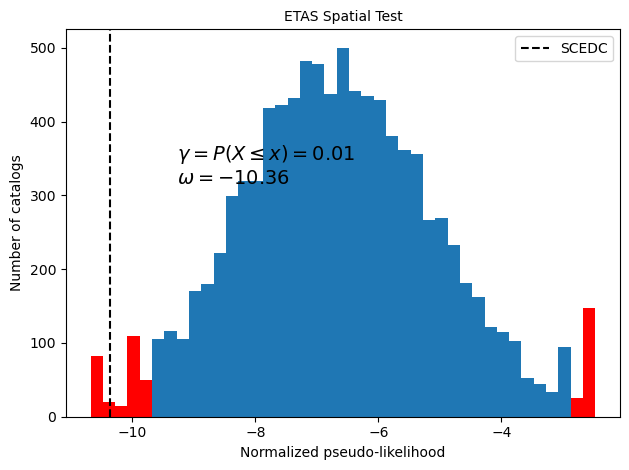

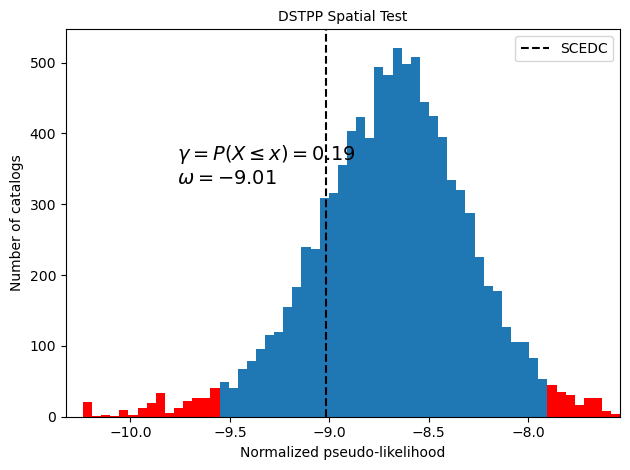

In [36]:
spatial_test_result = csep.core.catalog_evaluations.spatial_test(ETAS_forecast, cat, verbose=False)
ax = spatial_test_result.plot(plot_args={'title': 'ETAS Spatial Test'},show=True)
plt.show()
# spatial_test_result = csep.core.catalog_evaluations.spatial_test(SMASH_forecast, cat, verbose=False)
# ax = spatial_test_result.plot(plot_args={'title': 'SMASH Spatial Test'},show=True)
# plt.show()
spatial_test_result = csep.core.catalog_evaluations.spatial_test(DSTPP_forecast, cat, verbose=False)
ax = spatial_test_result.plot(plot_args={'title': 'DSTPP Spatial Test'},show=True)
plt.show()

# Pseudo-likelihood test

Found -inf as the observed likelihood score. Assuming event(s) occurred in undersampled region of forecast.
Recomputing with 329.0 events after removing 63.0 events.


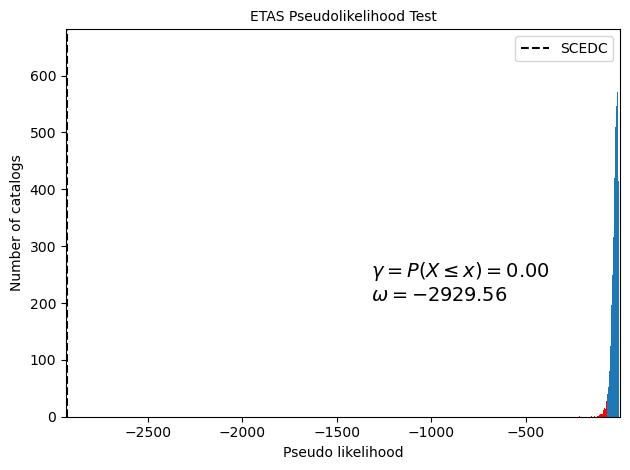

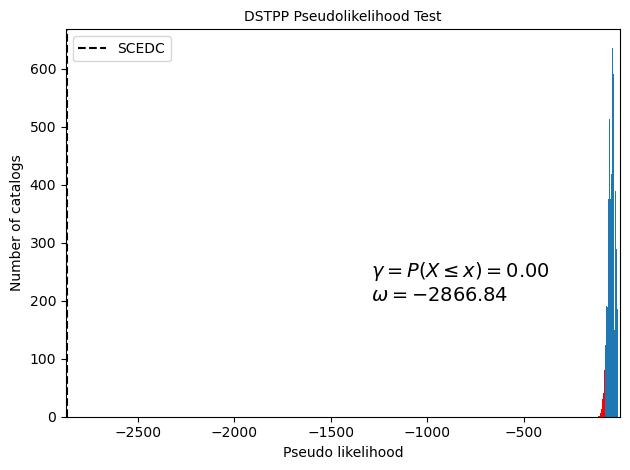

In [37]:
pseudo_test_result = csep.core.catalog_evaluations.pseudolikelihood_test(ETAS_forecast, cat, verbose=False)
ax = pseudo_test_result.plot(plot_args={'title': 'ETAS Pseudolikelihood Test'},show=True)
plt.show()
# pseudo_test_result = csep.core.catalog_evaluations.pseudolikelihood_test(SMASH_forecast, cat, verbose=False)
# ax = pseudo_test_result.plot(plot_args={'title': 'SMASH Pseudolikelihood Test'},show=True)
# plt.show()
pseudo_test_result = csep.core.catalog_evaluations.pseudolikelihood_test(DSTPP_forecast, cat, verbose=False)
ax = pseudo_test_result.plot(plot_args={'title': 'DSTPP Pseudolikelihood Test'},show=True)
plt.show()

## Magnitude test

Aim: The magnitude test aims to test the consistency of the observed frequency-magnitude distribution with that in the simulated catalogs that make up the forecast.

Method: We first define the union catalog $\$\Lambda_U$ as the union of all simulated catalogs in the forecast. Formally:

$$ \Lambda_U = { \lambda_1 \cup \lambda_2 \cup ... \cup \lambda_j } $$

so that the union catalog contains all events across all simulated catalogs for a total of $N_U = \sum_{j=1}^{J} \big{|}\lambda_j\big{|}$ events. We then compute the following histograms discretised to the magnitude range and magnitude step size (specified earlier for pyCSEP): 1. the histogram of the union catalog magnitudes $\Lambda_U^{(m)}$ 2. Histograms of magnitudes in each of the individual simulated catalogs $\lambda_j^{(m)}$ 3. the histogram of the observed catalog magnitudes $\Omega^{(m)}$.

The histograms are normalized so that the total number of events across all bins is equal to the observed number. The observed statistic is then calculated as the sum of squared logarithmic residuals between the normalised observed magnitudes and the union histograms. This statistic is related to the Kramer von-Mises statistic.

$$ d_{obs}= \sum_{k}\Bigg(\log\Bigg[\frac{N_{obs}}{N_U} \Lambda_U^{(m)}(k) + 1\Bigg]- \log\Big[\Omega^{(m)}(k) + 1\Big]\Bigg)^2$$

where $\Lambda_U^{(m)}(k)$ and $\Omega^{(m)}(k)$ represent the count in the $k^{th}$ bin of the magnitude-frequency distribution in the union and observed catalogs respectively. We add unity to each bin to avoid $\log(0)$. We then build the test distribution from the catalogs in $\boldsymbol{\Lambda}$:

$$ D_j = \sum_{k}\Bigg(\log\Bigg[\frac{N_{obs}}{N_U} \Lambda_U^{(m)}(k) + 1\Bigg]- \log\Bigg[\frac{N_{obs}}{N_j}\Lambda_j^{(m)}(k) + 1\Bigg]\Bigg)^2; j= 1...J$$

where $\lambda_j^{(m)}(k)$ represents the count in the $k^{th}$ bin of the magnitude-frequency distribution of the $j^{th}$ catalog.

The quantile score can then be calculated using the empirical CDF such that

$$\gamma_m = F_D(d_{obs})= P(D_j \leq d_{obs})$$

This can be performed in `pyCSEP` like this.

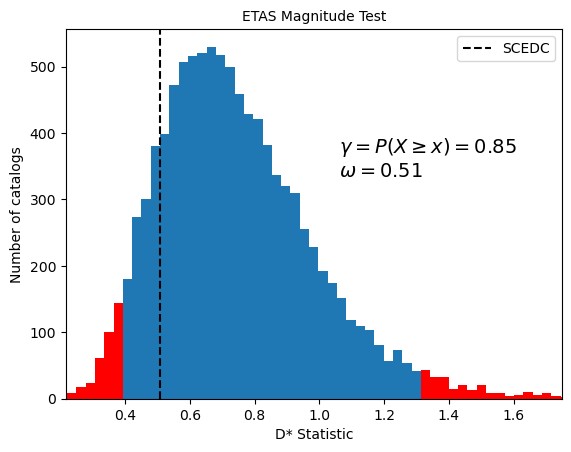

NameError: name 'SMASH_forecast' is not defined

In [17]:
magnitude_test_result = csep.core.catalog_evaluations.magnitude_test(ETAS_forecast, cat,verbose = False)
ax = magnitude_test_result.plot(plot_args={'title': 'ETAS Magnitude Test'},show=True)
plt.show()
magnitude_test_result = csep.core.catalog_evaluations.magnitude_test(SMASH_forecast, cat,verbose = False)
ax = magnitude_test_result.plot(plot_args={'title': 'SMASH Magnitude Test'},show=True)
plt.show()
magnitude_test_result = csep.core.catalog_evaluations.magnitude_test(DSTPP_forecast, cat,verbose = False)
ax = magnitude_test_result.plot(plot_args={'title': 'DSTPP Magnitude Test'},show=True)
plt.show()